# Imaging and deconvolution demonstration

This script makes a fake data set and then deconvolves it. Finally the full and residual visibility are plotted.

In [1]:
%matplotlib inline

import os
import sys

sys.path.append(os.path.join('..', '..'))

from data_models.parameters import arl_path
results_dir = arl_path('test_results')


from matplotlib import pylab

pylab.rcParams['figure.figsize'] = (8.0, 8.0)
pylab.rcParams['image.cmap'] = 'rainbow'

import numpy

from astropy.coordinates import SkyCoord
from astropy import units as u
from astropy.wcs.utils import pixel_to_skycoord

from matplotlib import pyplot as plt

from processing_components.image import  image_raster_iter

from processing_components.visibility import create_visibility
from processing_components.skycomponent import create_skycomponent
from processing_components.image import show_image, export_image_to_fits
from processing_components.image import  deconvolve_cube, restore_cube
from processing_components.visibility import  vis_timeslice_iter
from processing_components.simulation.configurations import create_named_configuration
from processing_components.simulation.testing_support import create_test_image
from processing_components.imaging import create_image_from_visibility
from processing_components.imaging import advise_wide_field

from workflows.serial.imaging.imaging_serial import invert_list_serial_workflow, predict_list_serial_workflow

from data_models.polarisation import PolarisationFrame

import logging

log = logging.getLogger()
log.setLevel(logging.DEBUG)
log.addHandler(logging.StreamHandler(sys.stdout))

mpl_logger = logging.getLogger("matplotlib") 
mpl_logger.setLevel(logging.WARNING) 

In [2]:
pylab.rcParams['figure.figsize'] = (12.0, 12.0)
pylab.rcParams['image.cmap'] = 'rainbow'

Construct LOW core configuration

In [3]:
lowr3 = create_named_configuration('LOWBD2', rmax=750.0)

LOWBD2
	(<Quantity -2544285.76809868 m>, <Quantity 5103070.08431238 m>, <Quantity -2848693.63167071 m>)
	GeodeticLocation(lon=<Longitude 116.4999 deg>, lat=<Latitude -26.7 deg>, height=<Quantity 300. m>)
create_configuration_from_file: Maximum radius 750.0 m includes 236 antennas/stations
[-2545983.21949368  5104856.98683873 -2852914.16896517]


In [4]:
print(lowr3.xyz)

[[-2545983.21949368  5104856.98683873 -2852914.16896517]
 [-2546185.01380468  5104746.30561217 -2852694.10384143]
 [-2546035.10056168  5104813.12493769 -2852826.9592822 ]
 [-2546265.88100668  5104811.152585   -2852823.03769538]
 [-2546083.33189368  5104781.73855973 -2852764.55441586]
 [-2546142.68682568  5104704.55486745 -2852611.09172557]
 [-2546139.85921368  5104755.56346844 -2852712.51103972]
 [-2546127.70172968  5104805.53831985 -2852811.87497164]
 [-2545996.46068868  5104756.98228663 -2852715.3320457 ]
 [-2546284.51583968  5104762.51147862 -2852726.32562029]
 [-2546228.03834568  5104761.82361752 -2852724.95796071]
 [-2545940.75549368  5104724.81905679 -2852651.38258132]
 [-2546120.75103668  5104832.97495556 -2852866.42664965]
 [-2546078.23721068  5104820.80334512 -2852842.22609603]
 [-2546168.30972068  5104779.54904667 -2852760.20105371]
 [-2546347.89420068  5104784.53197954 -2852770.10851292]
 [-2546075.02344868  5104745.83435203 -2852693.16684493]
 [-2545946.43562968  5104754.13

We create the visibility. This just makes the uvw, time, antenna1, antenna2, weight columns in a table

In [5]:
times = numpy.zeros([1])
frequency = numpy.array([1e8])
channel_bandwidth = numpy.array([1e6])
phasecentre = SkyCoord(ra=+15.0 * u.deg, dec=-45.0 * u.deg, frame='icrs', equinox='J2000')
vt = create_visibility(lowr3, times, frequency, channel_bandwidth=channel_bandwidth,
                       weight=1.0, phasecentre=phasecentre, polarisation_frame=PolarisationFrame('stokesI'))

create_visibility: 27730 rows, 0.003 GB
create_visibility: flagged 0/27730 visibilities below elevation limit 0.100000 (rad)
create_visibility: flagged 0/27730 visibilities below elevation limit 0.100000 (rad)


In [6]:
advice = advise_wide_field(vt, guard_band_image=3.0, delA=0.1, facets=1, wprojection_planes=1, 
                           oversampling_synthesised_beam=4.0)
cellsize = advice['cellsize']

advise_wide_field: Maximum wavelength 2.998 (meters)
advise_wide_field: Minimum wavelength 2.998 (meters)
advise_wide_field: Maximum baseline 383.0 (wavelengths)
advise_wide_field: Station/antenna diameter 35.0 (meters)
advise_wide_field: Primary beam 0.0857 (rad) 4.91 (deg)
advise_wide_field: Image field of view 0.257 (rad) 14.7 (deg)
advise_wide_field: Synthesized beam 0.00261 (rad) 0.15 (deg)
advise_wide_field: Cellsize 0.000653 (rad) 0.0374 (deg)
advice_wide_field: Npixels per side = 394
advice_wide_field: Npixels (power of 2) per side = 512
advice_wide_field: Npixels (power of 2, 3) per side = 512
advice_wide_field: W sampling for full image = 2.2 (wavelengths)
advice_wide_field: W sampling for primary beam = 19.4 (wavelengths)
advice_wide_field: Time sampling for full image = 154.8 (s)
advice_wide_field: Time sampling for primary beam = 1393.3 (s)
advice_wide_field: Frequency sampling for full image = 179176.4 (Hz)
advice_wide_field: Frequency sampling for primary beam = 1612587.

Plot the synthesized uv coverage.

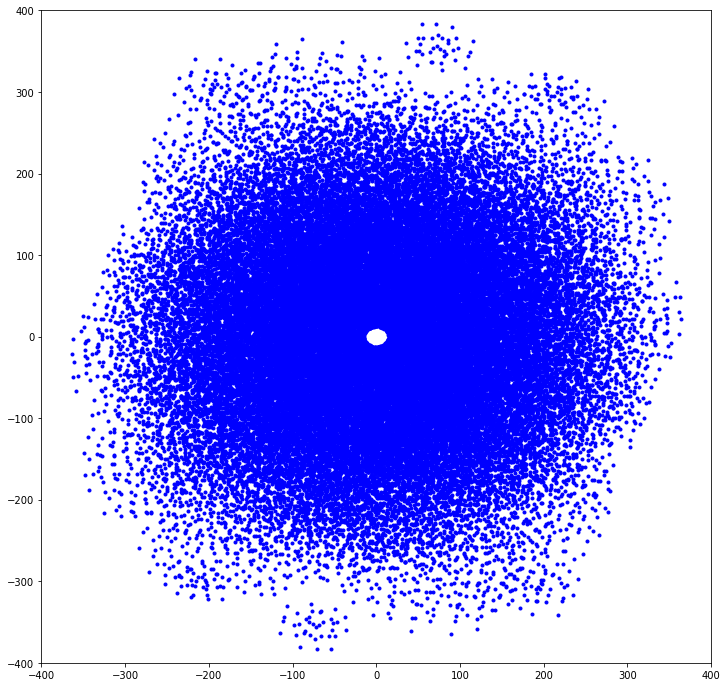

In [7]:
plt.clf()
plt.plot(vt.data['uvw'][:,0], vt.data['uvw'][:,1], '.', color='b')
plt.plot(-vt.data['uvw'][:,0], -vt.data['uvw'][:,1], '.', color='b')
plt.xlim([-400.0, 400.0])
plt.ylim([-400.0, 400.0])
plt.show()

Read the venerable test image, constructing an image

import_image_from_fits: created >f4 image of shape (256, 256), size 0.000 (GB)
import_image_from_fits: Max, min in /Users/timcornwell/Code/algorithm-reference-library/data/models/M31.MOD = 1.006458, 0.000000
replicate_image: replicating shape (256, 256) to (1, 1, 256, 256)


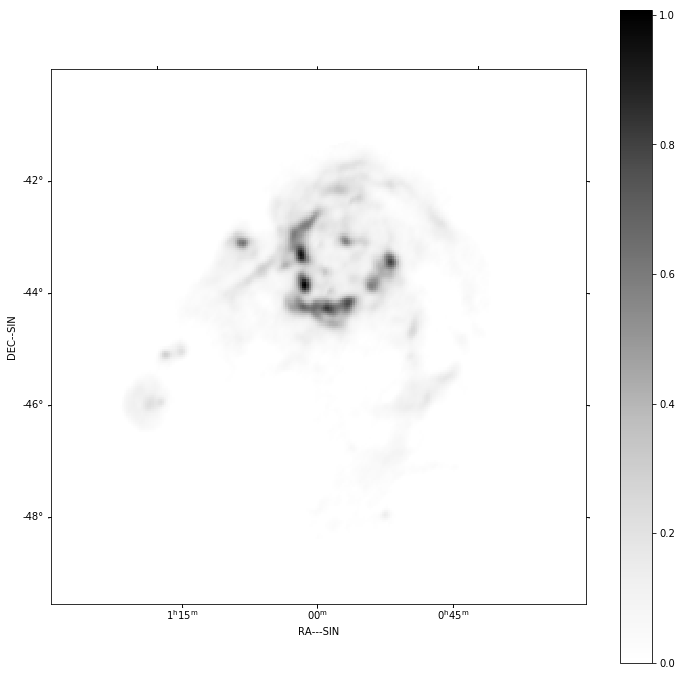

In [8]:
m31image = create_test_image(frequency=frequency, cellsize=cellsize)
nchan, npol, ny, nx = m31image.data.shape
m31image.wcs.wcs.crval[0] = vt.phasecentre.ra.deg
m31image.wcs.wcs.crval[1] = vt.phasecentre.dec.deg
m31image.wcs.wcs.crpix[0] = float(nx // 2)
m31image.wcs.wcs.crpix[1] = float(ny // 2)

fig=show_image(m31image)

shift_vis_from_image: shifting phasecentre from image phase centre <SkyCoord (ICRS): (ra, dec) in deg
    (14.94714238, -44.96258742)> to visibility phasecentre <SkyCoord (ICRS): (ra, dec) in deg
    (15., -45.)>


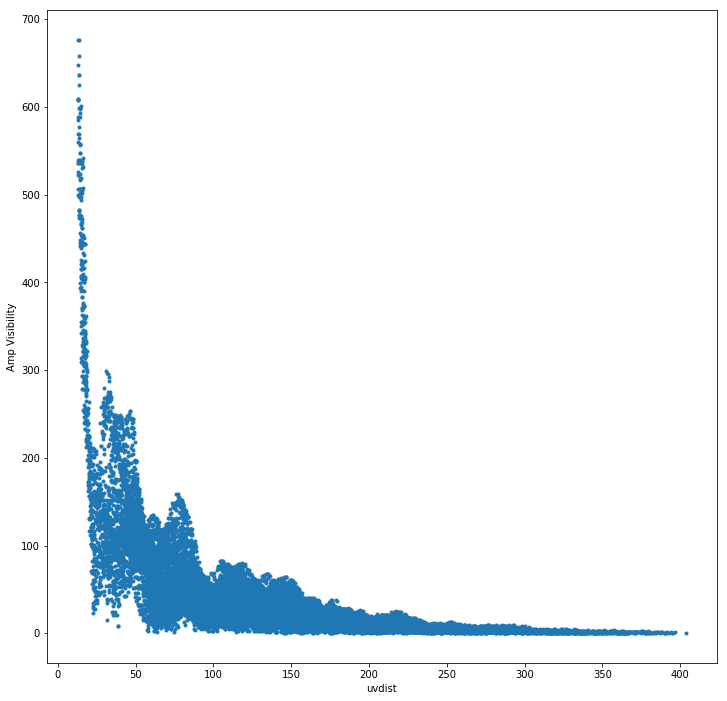

In [9]:
vt = predict_list_serial_workflow([vt], [m31image], context='2d')[0]

# To check that we got the prediction right, plot the amplitude of the visibility.
uvdist=numpy.sqrt(vt.data['uvw'][:,0]**2+vt.data['uvw'][:,1]**2)
plt.clf()
plt.plot(uvdist, numpy.abs(vt.data['vis']), '.')
plt.xlabel('uvdist')
plt.ylabel('Amp Visibility')
plt.show()

Make the dirty image and point spread function

create_image_from_visibility: Parsing parameters to get definition of WCS
create_image_from_visibility: Defining single channel Image at <SkyCoord (ICRS): (ra, dec) in deg
    (15., -45.)>, starting frequency 100000000.0 Hz, and bandwidth 999999.99999 Hz
create_image_from_visibility: uvmax = 363.929962 wavelengths
create_image_from_visibility: Critical cellsize = 0.001374 radians, 0.078718 degrees
create_image_from_visibility: Cellsize          = 0.00065276 radians, 0.0374004 degrees
create_image_from_visibility: image shape is [1, 1, 512, 512]
Max, min in dirty image = 14.032041, -3.384211, sumwt = 27730.000000
Max, min in PSF         = 0.999216, -0.010932, sumwt = 27730.000000


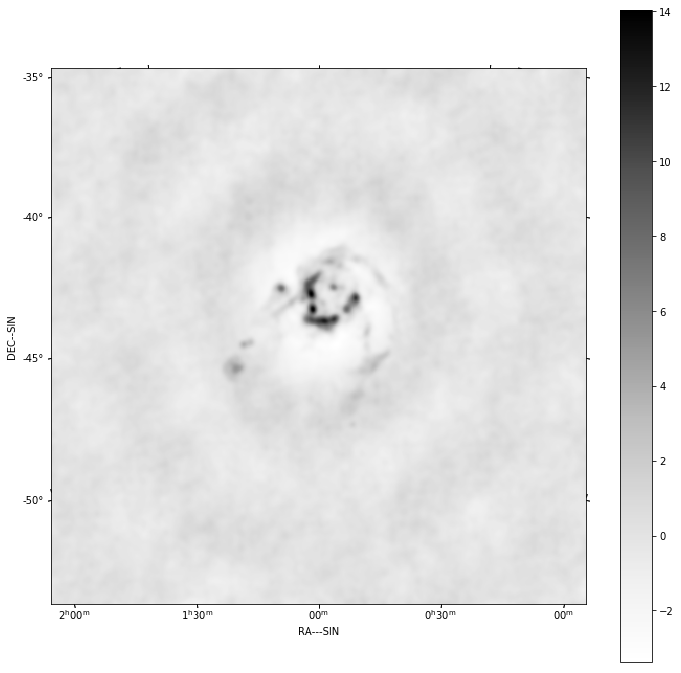

In [10]:
model = create_image_from_visibility(vt, cellsize=cellsize, npixel=512)
dirty, sumwt = invert_list_serial_workflow([vt], [model], context='2d')[0]
psf, sumwt = invert_list_serial_workflow([vt], [model], context='2d', dopsf=True)[0]

show_image(dirty)
print("Max, min in dirty image = %.6f, %.6f, sumwt = %f" % (dirty.data.max(), dirty.data.min(), sumwt))

print("Max, min in PSF         = %.6f, %.6f, sumwt = %f" % (psf.data.max(), psf.data.min(), sumwt))

export_image_to_fits(dirty, '%s/imaging_dirty.fits'%(results_dir))
export_image_to_fits(psf, '%s/imaging_psf.fits'%(results_dir))

Deconvolve using clean

deconvolve_cube : Cleaning inner quarter of each sky plane
deconvolve_cube : PSF support = +/- 256 pixels
deconvolve_cube : PSF shape (1, 1, 512, 512)
deconvolve_cube : Multi-scale clean of each polarisation and channel separately
deconvolve_cube : Processing pol 0, channel 0
msclean : Peak of PSF = 0.9992163257898287 at (256, 256)
msclean : Peak of Dirty = 14.032041 Jy/beam at (296, 248) 
msclean : Coupling matrix =
 [[1.         0.97145834 0.65775615 0.16083516]
 [0.97145834 0.94434792 0.6446799  0.16005303]
 [0.65775615 0.6446799  0.48814111 0.14887996]
 [0.16083516 0.16005303 0.14887996 0.09028873]]
msclean : Max abs in dirty Image = 14.043046 Jy/beam
msclean : Start of minor cycle
msclean : This minor cycle will stop at 10000 iterations or peak < 0.014043 (Jy/beam)
msclean : Timing for setup: 0.750 (s) for dirty shape (512, 512), PSF shape (512, 512) , scales [0, 3, 10, 30]
msclean : Minor cycle 0, peak [12.14574656 12.07817744 11.20193642  7.86438099] at [269, 261, 3]
msclean : M

Text(0.5, 1.0, 'Restored')

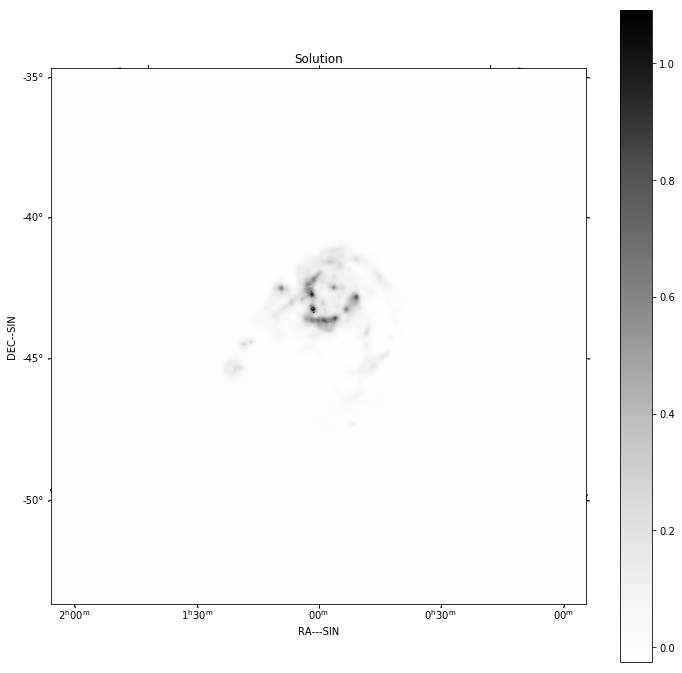

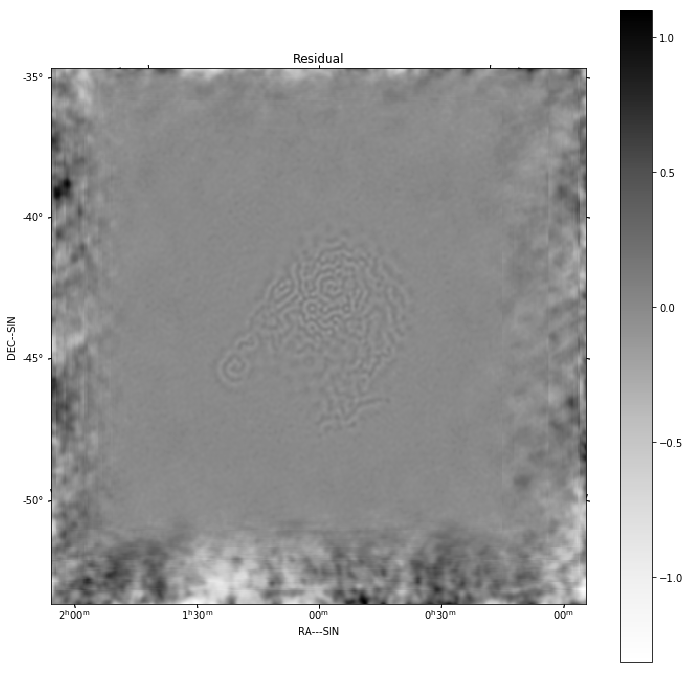

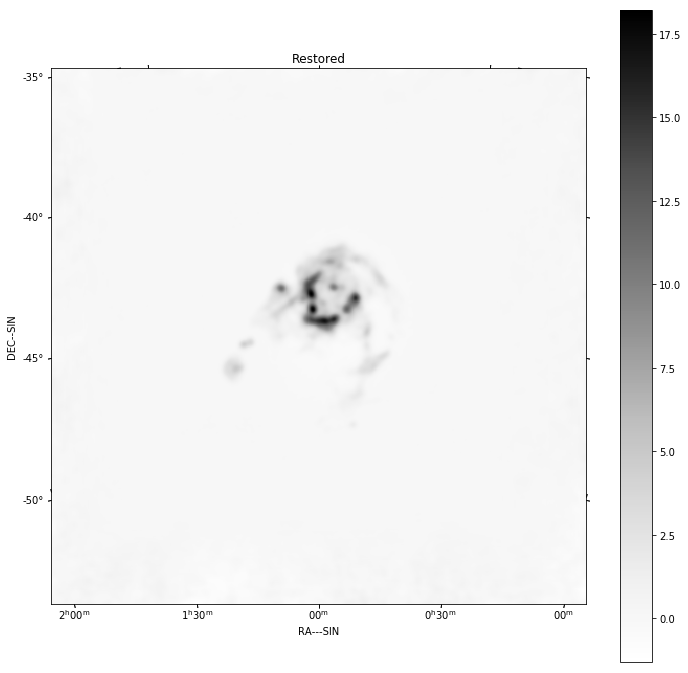

In [11]:
comp, residual = deconvolve_cube(dirty, psf, niter=10000, threshold=0.001, fractional_threshold=0.001,
                                 window_shape='quarter', gain=0.7, scales=[0, 3, 10, 30])

restored = restore_cube(comp, psf, residual)

# Show the results

fig=show_image(comp)
plt.title('Solution')
fig=show_image(residual)
plt.title('Residual')
fig=show_image(restored)
plt.title('Restored')

Predict the visibility of the model

In [12]:
vtmodel = create_visibility(lowr3, times, frequency, channel_bandwidth=channel_bandwidth,
                            weight=1.0, phasecentre=phasecentre, 
                            polarisation_frame=PolarisationFrame('stokesI'))
vtmodel=predict_list_serial_workflow([vtmodel], [comp], context='2d')[0]

create_visibility: 27730 rows, 0.003 GB
create_visibility: flagged 0/27730 visibilities below elevation limit 0.100000 (rad)
create_visibility: flagged 0/27730 visibilities below elevation limit 0.100000 (rad)


Now we will plot the original visibility and the residual visibility.

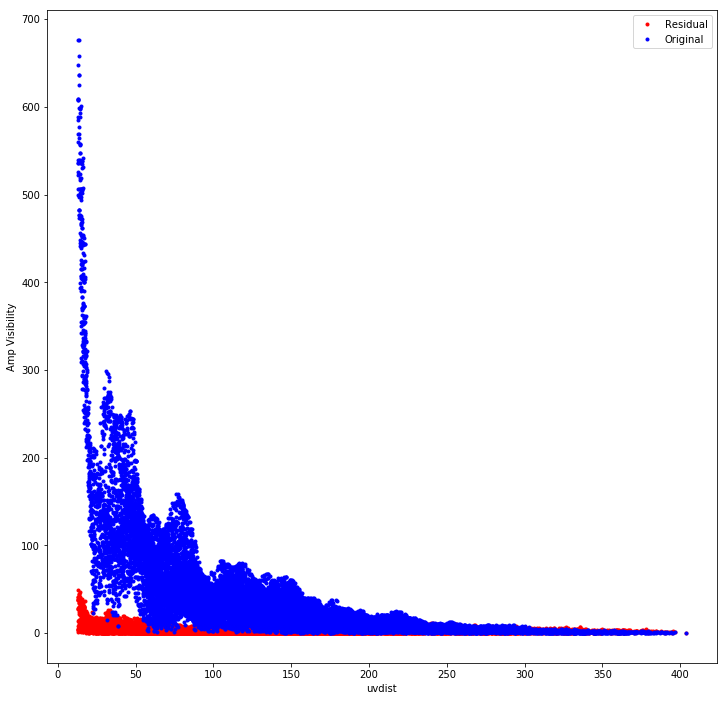

In [13]:
uvdist=numpy.sqrt(vt.data['uvw'][:,0]**2+vt.data['uvw'][:,1]**2)
plt.clf()
plt.plot(uvdist, numpy.abs(vt.data['vis'][:]-vtmodel.data['vis'][:]), '.', color='r', 
         label='Residual')
plt.plot(uvdist, numpy.abs(vt.data['vis'][:]), '.', color='b', label='Original')

plt.xlabel('uvdist')
plt.ylabel('Amp Visibility')
plt.legend()
plt.show()
